### 1. Feladat

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Stílus beállítása
sns.set(style='whitegrid')

# ---------------------------------------------------------
# 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE (A Te kódod alapján)
# ---------------------------------------------------------
print("Adatok betöltése és előkészítése...")

try:
    # Fájlok beolvasása (A 3 külön fájl)
    s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
    m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
    r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

    # Dátumok technikai igazítása (hogy biztosan egyezzenek)
    s.index = s.index.to_period('M').to_timestamp()
    m.index = m.index.to_period('M').to_timestamp()
    r.index = r.index.to_period('M').to_timestamp()

    # Kockázatmentes hozam előkészítése
    # Keressük meg a megfelelő oszlopot (bármi is a neve) és csináljuk meg a LAG-ot
    rf_col = r.columns[0]
    r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
    
    # FIGYELEM: A CAPM-hez szoktak Lag-ot használni, de itt most követjük a kérésedet
    rf_lag = r['Risk_Free_Rate'].shift(1) # Elcsúsztatás

    # Összefésülés a közös dátumokra
    df = s.join(m, how='inner').join(rf_lag, how='inner')

    # Piaci oszlop azonosítása és átnevezése
    market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
    df = df.rename(columns={market_col: 'SP100_rp'})

    # --- TÖBBLETHOZAM SZÁMÍTÁS ---
    # Kivonjuk a kockázatmentes hozamot (rf_lag) mindenből (Részvényekből és Piacból is)
    # (Kivéve magát a Risk_Free_Rate oszlopot)
    cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
    RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)

    # --- A TANÁR KÉRÉSE: OSZLOPOK TÖRLÉSE ---
    # 1. Először eldobjuk az első sort, mert a shift(1) miatt ott minden NaN
    RP = RP.iloc[1:]

    # 2. Most eldobjuk azokat az OSZLOPOKAT (részvényeket), ahol bárhol máshol hiány van
    # axis=1 jelenti az oszlopot
    original_count = len(RP.columns)
    RP_aligned = RP.dropna(axis=1, how='any')
    final_count = len(RP_aligned.columns)

    print(f"Eredeti részvények száma (piaccal): {original_count}")
    print(f"Megmaradt részvények száma (hiányosak törölve): {final_count}")
    print(f"Elemzett időszak hossza: {len(RP_aligned)} hónap")

    # ---------------------------------------------------------
    # VÁLTOZÓK ILLESZTÉSE A NOTEBOOK TOVÁBBI RÉSZEIHEZ
    # ---------------------------------------------------------
    # Mivel a notebook többi része 'stock_returns' és 'market_return' változókat vár,
    # itt létrehozzuk őket az általad betöltött 'RP_aligned' alapján.
    
    # Különválasztjuk a piaci hozamot a részvényektől
    market_return = RP_aligned['SP100_rp']
    
    # Minden oszlop, ami NEM a piaci hozam, az részvény
    stock_returns = RP_aligned.drop(columns=['SP100_rp'])
    
    # Megjegyzés: A 'stock_returns' itt most Többlethozam (Excess Return), 
    # de a momentum rangsorolás szempontjából ez is működik.

    print("\nAdatok sikeresen átadva az elemzésnek.")
    print(f"Használt részvények (stock_returns): {stock_returns.shape[1]} db")

except FileNotFoundError:
    print("HIBA: Nem találhatók a fájlok (monthly_stock_returns.csv, stb.)!")
    print("Kérlek, futtasd le az új 'downloader.ipynb'-t, ami létrehozza a 3 külön CSV fájlt.")
except Exception as e:
    print(f"Hiba történt: {e}")

Adatok betöltése és előkészítése...
Eredeti részvények száma (piaccal): 102
Megmaradt részvények száma (hiányosak törölve): 89
Elemzett időszak hossza: 285 hónap

Adatok sikeresen átadva az elemzésnek.
Használt részvények (stock_returns): 88 db


--- 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE ---
Eredeti részvények száma (piaccal): 102
Megmaradt részvények száma (tisztítva): 88
Elemzett időszak: 2002-02-01 -> 2025-10-01

Momentum szignál számítása (12-2)...
Momentum szignál kész.
Portfóliók képzése (Long: Top 10%, Short: Bottom 10%)...

--- EREDMÉNYEK ---
Átlagos havi hozam: 0.06%
Évesített átlaghozam: 0.74%
Évesített volatilitás: 23.94%
Sharpe-ráta: 0.03
CRASH (Min. havi): -39.31% (2009-04)


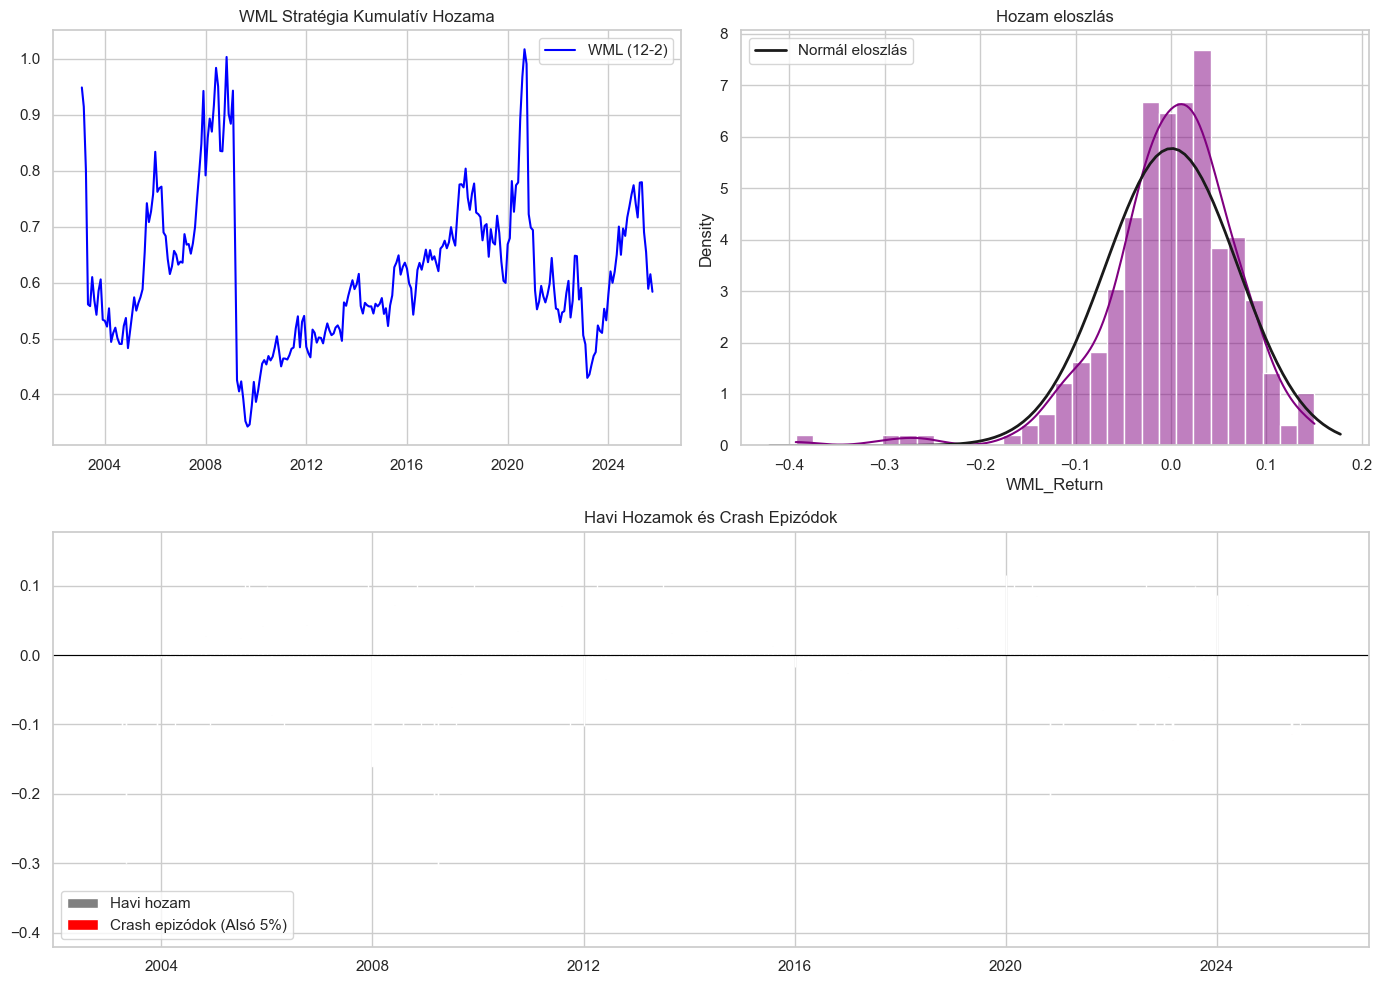

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Stílus beállítása
sns.set(style='whitegrid')

# ---------------------------------------------------------
# 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE
# ---------------------------------------------------------
print("--- 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE ---")

try:
    # Fájlok beolvasása (A 3 külön fájl)
    s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
    m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
    r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

    # Dátumok technikai igazítása (hogy biztosan egyezzenek)
    s.index = s.index.to_period('M').to_timestamp()
    m.index = m.index.to_period('M').to_timestamp()
    r.index = r.index.to_period('M').to_timestamp()

    # Kockázatmentes hozam előkészítése
    rf_col = r.columns[0]
    r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
    
    # Lag-olt RF (az előző havi RF a kockázatmentes hozam az adott hónapra)
    rf_lag = r['Risk_Free_Rate'].shift(1)

    # Összefésülés a közös dátumokra
    df = s.join(m, how='inner').join(rf_lag, how='inner')

    # Piaci oszlop azonosítása (bármi is a neve, pl. 'Adj Close' vagy '^OEX')
    market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
    df = df.rename(columns={market_col: 'SP100_rp'})

    # --- TÖBBLETHOZAM (EXCESS RETURN) SZÁMÍTÁS ---
    # Kivonjuk a kockázatmentes hozamot mindenből
    cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
    RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)

    # --- TISZTÍTÁS (TANÁRI KÉRÉS ALAPJÁN) ---
    # 1. Eldobjuk az első sort (shift miatt NaN)
    RP = RP.iloc[1:]

    # 2. Eldobjuk azokat az OSZLOPOKAT, ahol hiány van (pl. fiatal cégek: FB, TSLA)
    original_count = len(RP.columns)
    RP_aligned = RP.dropna(axis=1, how='any')
    
    # 3. Változók szétválasztása a további elemzéshez
    market_return = RP_aligned['SP100_rp']
    stock_returns = RP_aligned.drop(columns=['SP100_rp'])

    print(f"Eredeti részvények száma (piaccal): {original_count}")
    print(f"Megmaradt részvények száma (tisztítva): {len(stock_returns.columns)}")
    print(f"Elemzett időszak: {stock_returns.index[0].date()} -> {stock_returns.index[-1].date()}")
    
    # ---------------------------------------------------------
    # 2. MOMENTUM SZIGNÁL GENERÁLÁSA (12-2)
    # ---------------------------------------------------------
    print("\nMomentum szignál számítása (12-2)...")
    
    # (1+r).prod() - 1 logikával (compounding)
    momentum_signal = (1 + stock_returns.shift(2)).rolling(window=11).apply(np.prod, raw=True) - 1
    
    print("Momentum szignál kész.")

    # ---------------------------------------------------------
    # 3. WML PORTFÓLIÓ KONSTRUÁLÁSA
    # ---------------------------------------------------------
    print("Portfóliók képzése (Long: Top 10%, Short: Bottom 10%)...")
    
    wml_returns = []
    dates = []

    for date, row in momentum_signal.iterrows():
        # Ellenőrzés: van-e adat az adott napra
        if row.isnull().all() or date not in stock_returns.index:
            continue
            
        # Napi momentum értékek (szignál)
        valid_signals = row.dropna()
        
        if len(valid_signals) < 10: 
            # Ha a tisztítás miatt túl kevés cég maradt, kihagyjuk
            continue

        # Küszöbértékek (Decilisek)
        p10 = valid_signals.quantile(0.10) # Short
        p90 = valid_signals.quantile(0.90) # Long
        
        # Részvények kiválasztása
        long_candidates = valid_signals[valid_signals >= p90].index
        short_candidates = valid_signals[valid_signals <= p10].index
        
        # Hozamok lekérése
        current_month_rets = stock_returns.loc[date]
        
        # Equal Weighted Portfólió
        r_long = current_month_rets[long_candidates].mean()
        r_short = current_month_rets[short_candidates].mean()
        
        # WML = Long - Short
        wml = r_long - r_short
        
        wml_returns.append(wml)
        dates.append(date)

    # Eredmény Series
    wml_series = pd.Series(wml_returns, index=dates).dropna()
    wml_series.name = "WML_Return"
    
    # ---------------------------------------------------------
    # 4. EREDMÉNYEK ÉS VIZUALIZÁCIÓ
    # ---------------------------------------------------------
    print("\n--- EREDMÉNYEK ---")
    
    # Mutatók
    mean_monthly = wml_series.mean()
    mean_annualized = mean_monthly * 12
    vol_monthly = wml_series.std()
    vol_annualized = vol_monthly * np.sqrt(12)
    sharpe = mean_annualized / vol_annualized
    min_return = wml_series.min()
    crash_date = wml_series.idxmin() if not wml_series.empty else None
    
    print(f"Átlagos havi hozam: {mean_monthly:.2%}")
    print(f"Évesített átlaghozam: {mean_annualized:.2%}")
    print(f"Évesített volatilitás: {vol_annualized:.2%}")
    print(f"Sharpe-ráta: {sharpe:.2f}")
    if crash_date:
        print(f"CRASH (Min. havi): {min_return:.2%} ({crash_date.strftime('%Y-%m')})")

    # Vizualizáció
    cumulative_wml = (1 + wml_series).cumprod()
    
    plt.figure(figsize=(14, 10))
    
    # A) Kumulatív
    plt.subplot(2, 2, 1)
    plt.plot(cumulative_wml, label='WML (12-2)', color='blue')
    plt.title('WML Stratégia Kumulatív Hozama')
    plt.legend()
    plt.grid(True)
    
    # B) Hisztogram
    plt.subplot(2, 2, 2)
    sns.histplot(wml_series, kde=True, stat="density", color='purple', bins=30)
    # Normál görbe
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_monthly, vol_monthly)
    plt.plot(x, p, 'k', linewidth=2, label='Normál eloszlás')
    plt.title('Hozam eloszlás')
    plt.legend()
    
    # C) Crash epizódok
    plt.subplot(2, 1, 2)
    plt.bar(wml_series.index, wml_series.values, color='gray', label='Havi hozam')
    # Crash (< 5%)
    crashes = wml_series[wml_series < wml_series.quantile(0.05)]
    plt.bar(crashes.index, crashes.values, color='red', label='Crash epizódok (Alsó 5%)')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title('Havi Hozamok és Crash Epizódok')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Mentés CSV-be (hogy a többi cella is lássa, ha fájlból olvasnák)
    wml_series.to_csv('wml_returns_12_2.csv')

except FileNotFoundError:
    print("HIBA: Nem találhatók a fájlok (monthly_stock_returns.csv)!")
    print("Futtasd le az ÚJ downloader.ipynb kódot!")
except Exception as e:
    print(f"Váratlan hiba történt: {e}")

--- AUTOKORRELÁCIÓ ELEMZÉS ---

1. WML Stratégia (12-2) Lag-1 Autokorreláció:
   Korrelációs együttható (r): 0.1009
   Szignifikancia szint (p):   0.0966
   -> Eredmény: NEM SZIGNIFIKÁNS. A havi hozamok függetlennek tűnnek.

2. Egyedi részvények elemzése (SP100)...
   Elemzett részvények száma (ahol volt elég adat): 88
   Szignifikáns autokorrelációt mutatók száma: 9
   Arány: 10.2%


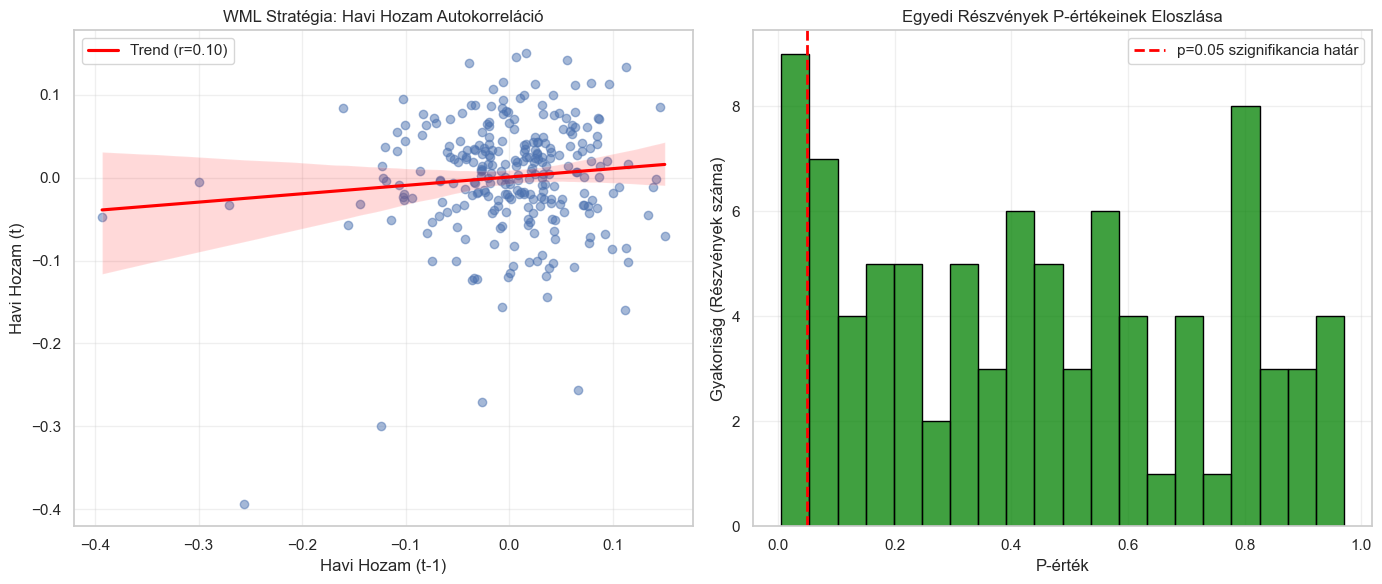

In [21]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stílus beállítása
sns.set(style='whitegrid')

# 1. ROBUSZTUS FÜGGVÉNY DEFINIÁLÁSA
def autocorr_with_pvalue(series, lag=1):
    """
    Kiszámolja a sorozat autokorrelációját (Pearson r) és a p-értéket.
    Biztonságosan kezeli a hiányzó adatokat (NaN) a lag-olásnál.
    """
    # Segéd DataFrame létrehozása a pontos időbeli illesztéshez
    aux = pd.DataFrame({'t': series, 't_lag': series.shift(lag)})
    
    # Eldobjuk azokat a sorokat, ahol nincs adat (vagy a t-ben, vagy a t-lag-ban)
    # Ez automatikusan kezeli a fiatal cégek hiányzó elejét is.
    aux = aux.dropna()
    
    # Ellenőrzés: van-e elég adat a statisztikához (pl. min 24 hónap)
    if len(aux) < 24:
        return np.nan, np.nan
    
    # Pearson korreláció és p-érték számítása
    r, p = pearsonr(aux['t'], aux['t_lag'])
    return r, p

print("--- AUTOKORRELÁCIÓ ELEMZÉS ---")

# Ellenőrizzük, hogy a változók léteznek-e (az előző cellából)
if 'wml_series' in locals() and 'stock_returns' in locals():
    
    # --- A) WML Stratégia Autokorrelációja (Lag-1) ---
    # Ez válaszol arra, hogy "ragadósak-e" a momentum stratégia hozamai
    r_wml, p_wml = autocorr_with_pvalue(wml_series, 1)
    
    print(f"\n1. WML Stratégia (12-2) Lag-1 Autokorreláció:")
    print(f"   Korrelációs együttható (r): {r_wml:.4f}")
    print(f"   Szignifikancia szint (p):   {p_wml:.4f}")
    
    if p_wml < 0.05:
        print("   -> Eredmény: SZIGNIFIKÁNS. A stratégia hozamai 'tapadósak' (momentum a momentumban).")
    else:
        print("   -> Eredmény: NEM SZIGNIFIKÁNS. A havi hozamok függetlennek tűnnek.")

    # --- B) Egyedi Részvények Elemzése ---
    print("\n2. Egyedi részvények elemzése (SP100)...")
    ac_results = []
    
    for ticker in stock_returns.columns:
        # Itt használjuk az új függvényt, ami kezeli a NaN-okat
        r, p = autocorr_with_pvalue(stock_returns[ticker], 1)
        
        # Csak akkor mentjük el, ha sikerült kiszámolni (nem NaN)
        if not np.isnan(r):
            ac_results.append({'Ticker': ticker, 'AC_Lag1': r, 'P_Value': p})
            
    ac_df = pd.DataFrame(ac_results)
    
    # Statisztika
    if not ac_df.empty:
        sig_stocks = ac_df[ac_df['P_Value'] < 0.05]
        print(f"   Elemzett részvények száma (ahol volt elég adat): {len(ac_df)}")
        print(f"   Szignifikáns autokorrelációt mutatók száma: {len(sig_stocks)}")
        print(f"   Arány: {len(sig_stocks)/len(ac_df):.1%}")
    else:
        print("   Nincs elegendő adat az egyedi részvények elemzéséhez.")

    # --- C) Vizualizáció ---
    plt.figure(figsize=(14, 6))

    # Bal: WML Scatter Plot (Hozam t vs t-1)
    plt.subplot(1, 2, 1)
    # Biztonságos ábrázolás: csak a közös adatokat vesszük
    wml_lagged = pd.DataFrame({'t': wml_series, 't_1': wml_series.shift(1)}).dropna()
    
    sns.regplot(data=wml_lagged, x='t_1', y='t', 
                scatter_kws={'alpha':0.5}, 
                line_kws={'color':'red', 'label': f'Trend (r={r_wml:.2f})'})
    
    plt.title(f"WML Stratégia: Havi Hozam Autokorreláció")
    plt.xlabel("Havi Hozam (t-1)")
    plt.ylabel("Havi Hozam (t)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Jobb: P-értékek hisztogramja (Egyedi részvények)
    if not ac_df.empty:
        plt.subplot(1, 2, 2)
        sns.histplot(ac_df['P_Value'], bins=20, color='green', edgecolor='black')
        plt.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05 szignifikancia határ')
        plt.title("Egyedi Részvények P-értékeinek Eloszlása")
        plt.xlabel("P-érték")
        plt.ylabel("Gyakoriság (Részvények száma)")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("HIBA: A 'wml_series' vagy 'stock_returns' változók nem találhatók.")
    print("Tipp: Kérlek futtasd le az előző cellát, amelyben a momentum stratégiát számoltuk és az adatokat betöltöttük!")

Autokorrelációs adatok számítása az SP100 részvényekre...


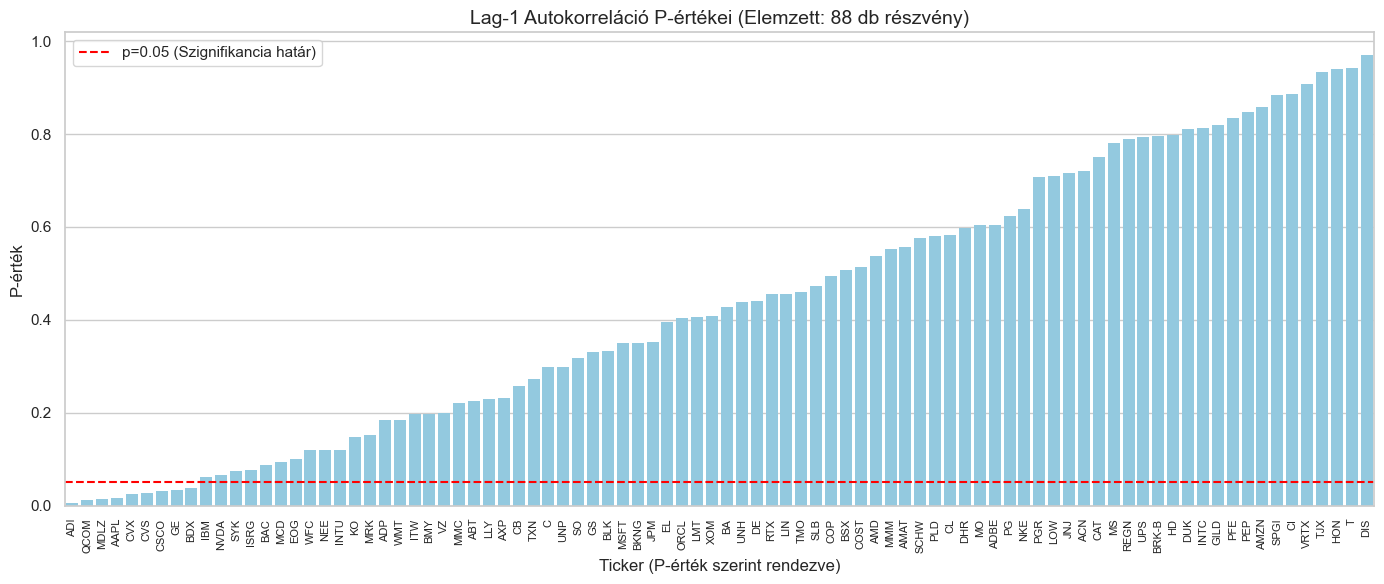

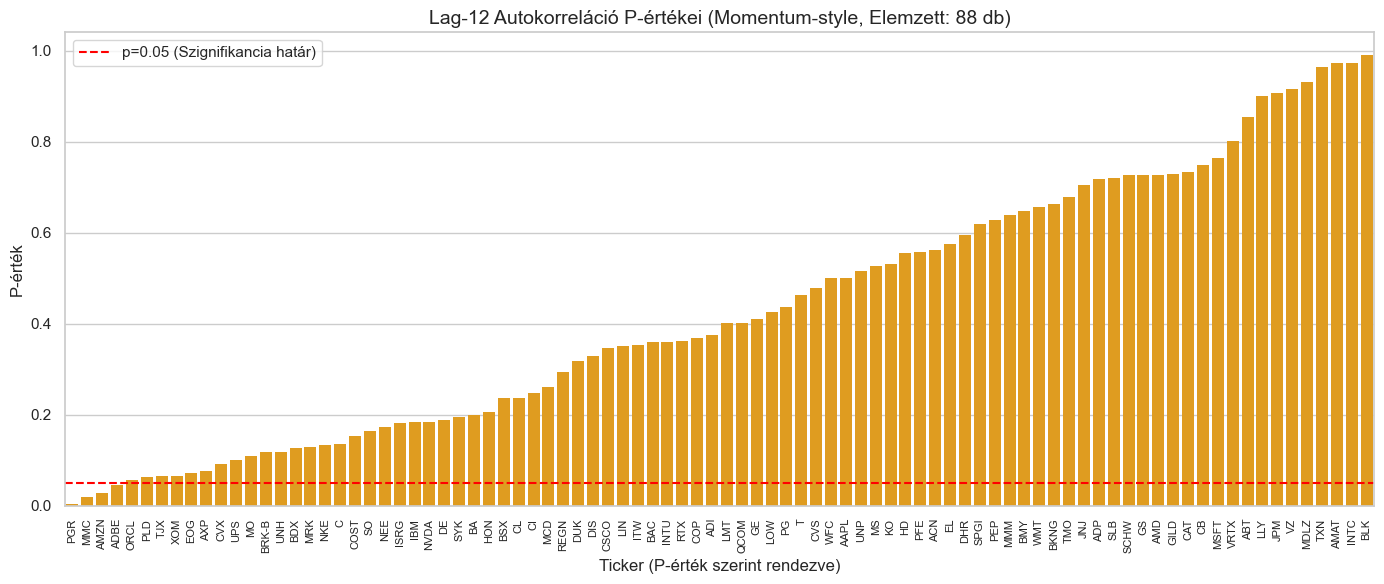

Összegzés:
Lag-1 szignifikáns:  9 db (10.2%)
Lag-12 szignifikáns: 4 db (4.5%)


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. ADATOK ELŐKÉSZÍTÉSE (SP100-ra)
# Ellenőrizzük, hogy a stock_returns betöltődött-e
if 'stock_returns' in locals():
    print("Autokorrelációs adatok számítása az SP100 részvényekre...")
    ac_results = []

    for ticker in stock_returns.columns:
        # FONTOS: Nem kell kézzel .dropna()-zni, mert az új 'autocorr_with_pvalue' 
        # függvény ezt belül elvégzi az idősoros illesztésnél.
        
        # Lag-1 (Rövid távú memória)
        r1, p1 = autocorr_with_pvalue(stock_returns[ticker], 1)
        
        # Lag-12 (Momentum jelleg - egy évvel ezelőtti hatás)
        r12, p12 = autocorr_with_pvalue(stock_returns[ticker], 12)
        
        # Csak akkor mentjük el, ha sikerült számolni (nem NaN az eredmény)
        if not np.isnan(p1) and not np.isnan(p12):
            ac_results.append({
                'Ticker': ticker,
                'ac1': r1, 'p1': p1,
                'ac12': r12, 'p12': p12
            })

    ac_df = pd.DataFrame(ac_results)

    if not ac_df.empty:
        # 2. ÁBRÁZOLÁS
        sns.set(style='whitegrid')

        # --- Lag-1 P-értékek ---
        plt.figure(figsize=(14, 6))
        # Sorbarendezzük a p-érték szerint a szebb ábráért
        sorted_df1 = ac_df.sort_values('p1')
        
        # Barplot készítése
        sns.barplot(data=sorted_df1, x='Ticker', y='p1', color='skyblue', edgecolor='none')
        
        # 0.05-ös szignifikancia szint (piros vonal)
        plt.axhline(0.05, color='red', linestyle='--', linewidth=1.5, label='p=0.05 (Szignifikancia határ)')
        
        plt.xticks(rotation=90, fontsize=8)
        # Ha túl sok a részvény, ritkíthatjuk a feliratokat, de itt most hagyjuk mindet
        plt.title(f"Lag-1 Autokorreláció P-értékei (Elemzett: {len(ac_df)} db részvény)", fontsize=14)
        plt.ylabel("P-érték")
        plt.xlabel("Ticker (P-érték szerint rendezve)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- Lag-12 P-értékek ---
        plt.figure(figsize=(14, 6))
        sorted_df12 = ac_df.sort_values('p12')
        
        sns.barplot(data=sorted_df12, x='Ticker', y='p12', color='orange', edgecolor='none')
        
        # 0.05-ös szignifikancia szint
        plt.axhline(0.05, color='red', linestyle='--', linewidth=1.5, label='p=0.05 (Szignifikancia határ)')
        
        plt.xticks(rotation=90, fontsize=8)
        plt.title(f"Lag-12 Autokorreláció P-értékei (Momentum-style, Elemzett: {len(ac_df)} db)", fontsize=14)
        plt.ylabel("P-érték")
        plt.xlabel("Ticker (P-érték szerint rendezve)")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Statisztika kiírása
        sig1 = len(ac_df[ac_df['p1'] < 0.05])
        sig12 = len(ac_df[ac_df['p12'] < 0.05])
        print(f"Összegzés:")
        print(f"Lag-1 szignifikáns:  {sig1} db ({sig1/len(ac_df):.1%})")
        print(f"Lag-12 szignifikáns: {sig12} db ({sig12/len(ac_df):.1%})")

    else:
        print("Nincs elegendő adat az ábrázoláshoz (vagy minden részvény túl rövid idősorral rendelkezik).")

else:
    print("HIBA: A 'stock_returns' változó nem található. Kérlek, futtasd le az adatbetöltő cellát először!")

In [23]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 12-2 MOMENTUM ÉS WML SZÁMÍTÁSA (TISZTÍTOTT ADATOKON)
# ---------------------------------------------------------

# Ellenőrizzük, hogy az előző lépés lefutott-e
if 'stock_returns' in locals():
    print(f"Momentum számítása a tisztított adatbázison ({stock_returns.shape[1]} részvény)...")

    # 1. MOMENTUM SZIGNÁL SZÁMÍTÁSA
    # Formációs időszak: t-12 -> t-2 (11 hónap), 1 hónap kihagyással (t-1)
    # Mivel a stock_returns már tisztított (nincs benne hiányos cég), 
    # a rolling ablak szépen végigfut mindenkin.
    momentum_12_2 = (1 + stock_returns.shift(2)).rolling(window=11).apply(np.prod, raw=True) - 1

    # 2. BACKTEST (WML HOZAMOK SZÁMÍTÁSA)
    wml_returns = []
    dates = []

    print("Havi WML hozamok generálása...")
    
    # Végigmegyünk minden hónapon
    for date, signal_row in momentum_12_2.iterrows():
        # Csak akkor számolunk, ha van adat az adott napra a hozamokban is
        if date not in stock_returns.index:
            continue
            
        # Kivesszük az érvényes momentum értékeket
        # (A tisztított adatbázis miatt itt elvileg nem lenne NaN, kivéve az első 12 hónapot)
        valid_signals = signal_row.dropna()
        
        # Kezdeti időszak átugrása (amíg nincs meg a 12 hónap múlt)
        if len(valid_signals) < 10:
            continue

        # --- KIVÁLASZTÁS (TOP 10% és BOTTOM 10%) ---
        p90 = valid_signals.quantile(0.90) # Felső 10% küszöb (Nyertesek)
        p10 = valid_signals.quantile(0.10) # Alsó 10% küszöb (Vesztesek)
        
        winners = valid_signals[valid_signals >= p90].index
        losers = valid_signals[valid_signals <= p10].index
        
        # --- HOZAM SZÁMÍTÁS (t hónapra) ---
        current_month_ret = stock_returns.loc[date]
        
        # Egyenlő súlyozású (Equal Weighted) portfólió hozamok
        long_ret = current_month_ret[winners].mean()
        short_ret = current_month_ret[losers].mean()
        
        # WML (Winners Minus Losers)
        wml = long_ret - short_ret
        
        wml_returns.append(wml)
        dates.append(date)

    # Eredmény konvertálása Series-be
    wml_series = pd.Series(wml_returns, index=dates).dropna()
    wml_series.name = "WML_Return_12_2"

    # 3. EREDMÉNYEK KIÍRÁSA (UTOLSÓ HÓNAP)
    last_date = momentum_12_2.index[-1]
    last_signal = momentum_12_2.iloc[-1].dropna()

    if not last_signal.empty:
        last_p90 = last_signal.quantile(0.90)
        last_p10 = last_signal.quantile(0.10)
        
        current_winners = last_signal[last_signal >= last_p90].index.tolist()
        current_losers = last_signal[last_signal <= last_p10].index.tolist()

        print(f"\n--- Utolsó dátum: {last_date.strftime('%Y-%m-%d')} ---")
        print(f"Winners (Top 10% - {len(current_winners)} db): {current_winners}")
        print(f"Losers (Bottom 10% - {len(current_losers)} db): {current_losers}")

    print(f"\nTeljes idősor hossza: {len(wml_series)} hónap")
    print(f"Átlagos havi WML hozam: {wml_series.mean():.2%}")
    print("Sikeres számítás!")

else:
    print("HIBA: A 'stock_returns' változó nem található.")
    print("Kérlek futtasd le az ELSŐ kódcellát (Adatbetöltés), hogy a tisztított adatok a memóriába kerüljenek!")

Momentum számítása a tisztított adatbázison (88 részvény)...
Havi WML hozamok generálása...

--- Utolsó dátum: 2025-10-01 ---
Winners (Top 10% - 9 db): ['BA', 'C', 'GE', 'GS', 'JPM', 'MS', 'NVDA', 'SCHW', 'WFC']
Losers (Bottom 10% - 9 db): ['ACN', 'ADBE', 'DHR', 'LMT', 'MRK', 'REGN', 'TMO', 'UNH', 'UPS']

Teljes idősor hossza: 273 hónap
Átlagos havi WML hozam: 0.06%
Sikeres számítás!


--- PORTFÓLIÓ KUMULATÍV HOZAMOK (Winners, Losers, Long-Short) ---
Kumulatív hozamok számítása 88 db 'tisztított' részvényen...

port_cumsum.tail() - Utolsó 5 hónap kumulatív értékei ($):
            Winners (Long)  Losers (Short)  WML Stratégia
2025-06-01       47.058906       23.625820       0.690346
2025-07-01       45.738920       24.183171       0.654696
2025-08-01       45.461038       26.462005       0.589025
2025-09-01       47.540076       26.506205       0.614979
2025-10-01       47.843817       28.026080       0.583645


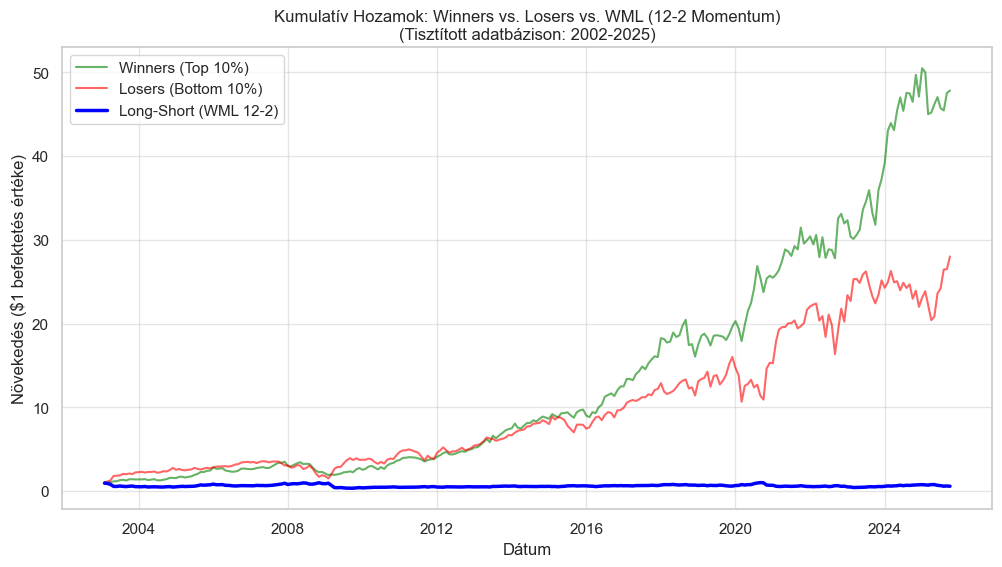

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- PORTFÓLIÓ KUMULATÍV HOZAMOK (Winners, Losers, Long-Short) ---")

# Változónevek ellenőrzése és egységesítése
# (Ha az előző kód 'momentum_12_2' néven mentette, itt átvesszük azt)
if 'momentum_12_2' in locals():
    momentum_signal = momentum_12_2
elif 'momentum_signal' not in locals():
    print("HIBA: Nem található a momentum adat (momentum_12_2 vagy momentum_signal)!")
    print("Futtasd le az előző cellát!")

# Fő ellenőrzés
if 'stock_returns' in locals() and 'momentum_signal' in locals():
    winners_list = []
    losers_list = []
    dates = []
    
    print(f"Kumulatív hozamok számítása {len(stock_returns.columns)} db 'tisztított' részvényen...")

    # Újra végigmegyünk az idősoron, hogy külön elmentsük a Winner/Loser hozamokat
    for date, row in momentum_signal.iterrows():
        # Csak akkor lépünk be, ha van adat a hozamokban is
        if date not in stock_returns.index: 
            continue
            
        # Mivel a tisztított adatbázist használjuk, itt elvileg nincs NaN, 
        # kivéve az első 12 hónapot (amíg nincs elég múlt).
        valid_signals = row.dropna()
        
        # Kezdeti időszak átugrása
        if len(valid_signals) < 10: 
            continue

        # 10%-os küszöbök (Decilisek)
        p10 = valid_signals.quantile(0.10) # Alsó 10%
        p90 = valid_signals.quantile(0.90) # Felső 10%
        
        # Ticker lista kiválasztása
        top10_tickers = valid_signals[valid_signals >= p90].index
        bottom10_tickers = valid_signals[valid_signals <= p10].index
        
        # Havi hozamok átlaga (Equal Weighted)
        # Itt a 'stock_returns' már a tisztított (RP_aligned) adatokat tartalmazza
        r_win = stock_returns.loc[date, top10_tickers].mean()
        r_lose = stock_returns.loc[date, bottom10_tickers].mean()
        
        winners_list.append(r_win)
        losers_list.append(r_lose)
        dates.append(date)

    # 1. A KÉRT VÁLTOZÓK LÉTREHOZÁSA
    winners_ret = pd.Series(winners_list, index=dates)
    losers_ret = pd.Series(losers_list, index=dates)
    
    # WML (Winners Minus Losers) - Long pozíció mínusz Short pozíció
    long_short = winners_ret - losers_ret

    # 2. KUMULATÍV HOZAM DATAFRAME (Compounding: (1+r).cumprod())
    port_cumsum = pd.DataFrame({
        'Winners (Long)': (1 + winners_ret).cumprod(),
        'Losers (Short)': (1 + losers_ret).cumprod(),
        'WML Stratégia': (1 + long_short).cumprod() 
    })

    # 3. KIÍRÁS (utolsó sorok ellenőrzése)
    print("\nport_cumsum.tail() - Utolsó 5 hónap kumulatív értékei ($):")
    print(port_cumsum.tail())

    # 4. ÁBRÁZOLÁS
    plt.figure(figsize=(12, 6))
    
    # Winners - Zöld
    plt.plot(port_cumsum['Winners (Long)'], label='Winners (Top 10%)', color='green', alpha=0.6)
    
    # Losers - Piros (Látni fogod, hogy ez általában kevésbé nő, vagy csökken)
    plt.plot(port_cumsum['Losers (Short)'], label='Losers (Bottom 10%)', color='red', alpha=0.6)
    
    # WML Stratégia - Kék (Ez a kettő különbsége, a végső stratégia)
    plt.plot(port_cumsum['WML Stratégia'], label='Long-Short (WML 12-2)', color='blue', linewidth=2.5)
    
    plt.title("Kumulatív Hozamok: Winners vs. Losers vs. WML (12-2 Momentum)\n(Tisztított adatbázison: 2002-2025)")
    plt.ylabel("Növekedés ($1 befektetés értéke)")
    plt.xlabel("Dátum")
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    # Kép mentése
    plt.savefig('wml_components_cumulative.png')
    plt.show()

else:
    print("HIBA: A 'stock_returns' vagy 'momentum_signal' változó nem található.")
    print("Kérlek, futtasd le sorban az előző kódcellákat!")

In [25]:
from scipy.stats import ttest_1samp
import pandas as pd

print("--- WML Stratégia: T-próba (Szignifikancia teszt) ---")

# 1. ADATOK KIVÁLASZTÁSA
# A kód megpróbálja megtalálni a legfrissebb WML hozam adatsort.
# A 2. lépésben 'wml_series' néven, a 3. lépésben 'long_short' néven dolgoztunk vele.
target_series = None

if 'wml_series' in locals():
    target_series = wml_series
    print("Adatforrás: 'wml_series' (a Momentum számításból)")
elif 'long_short' in locals():
    target_series = long_short
    print("Adatforrás: 'long_short' (a Kumulatív ábrából)")
else:
    print("HIBA: Nem található a WML hozam adatsor!")
    print("Kérlek futtasd le a 'Momentum számítása' (2. cella) részt!")

# 2. SZÁMÍTÁS ÉS TESZTELÉS
if target_series is not None:
    # Biztonsági tisztítás (bár a korábbi lépések már kezelték a NaN-okat)
    clean_series = target_series.dropna()
    
    # Átlagos havi hozam
    mean_ls = clean_series.mean()
    
    # Egymintás t-próba (Nullhipotézis: az átlaghozam = 0)
    # Azt vizsgáljuk, hogy a hozam statisztikailag különbözik-e a nullától.
    t_stat, p_val = ttest_1samp(clean_series, 0)

    # 3. KIÍRATÁS
    print(f"\nElemzett időszak hossza: {len(clean_series)} hónap")
    print(f"Átlagos havi WML hozam: {mean_ls:.4f} ({mean_ls:.2%})")
    print(f"t-statisztika: {t_stat:.4f}")
    print(f"p-érték:       {p_val:.4f}")
    
    # 4. ÉRTELMEZÉS
    print("\n--- Értelmezés ---")
    if p_val < 0.05:
        if t_stat > 0:
            print("✅ EREDMÉNY: SZIGNIFIKÁNS POZITÍV hozam.")
            print("   (A stratégia tartósan nyereségesnek tűnik, és ez nem a véletlen műve, p < 0.05)")
        else:
            print("❌ EREDMÉNY: SZIGNIFIKÁNS NEGATÍV hozam.")
            print("   (A stratégia tartósan veszteséges.)")
    else:
        print("⚠️ EREDMÉNY: NEM SZIGNIFIKÁNS.")
        print("   (Nem zárható ki, hogy az elért hozam csak a véletlen műve, mivel p >= 0.05)")
        print("   Ez gyakori lehet, ha a vizsgált időszakban nagy összeomlások (crashes) voltak,")
        print("   amelyek lerontották az átlagot.")

--- WML Stratégia: T-próba (Szignifikancia teszt) ---
Adatforrás: 'wml_series' (a Momentum számításból)

Elemzett időszak hossza: 273 hónap
Átlagos havi WML hozam: 0.0006 (0.06%)
t-statisztika: 0.1473
p-érték:       0.8830

--- Értelmezés ---
⚠️ EREDMÉNY: NEM SZIGNIFIKÁNS.
   (Nem zárható ki, hogy az elért hozam csak a véletlen műve, mivel p >= 0.05)
   Ez gyakori lehet, ha a vizsgált időszakban nagy összeomlások (crashes) voltak,
   amelyek lerontották az átlagot.


--- HIÁNYZÓ MUTATÓK ÉS VIZUALIZÁCIÓ (A feladat szerint) ---
Évesített Volatilitás: 23.94%
Sharpe-ráta: 0.03
CRASH (Legrosszabb hónap): -39.31% (2009-04)


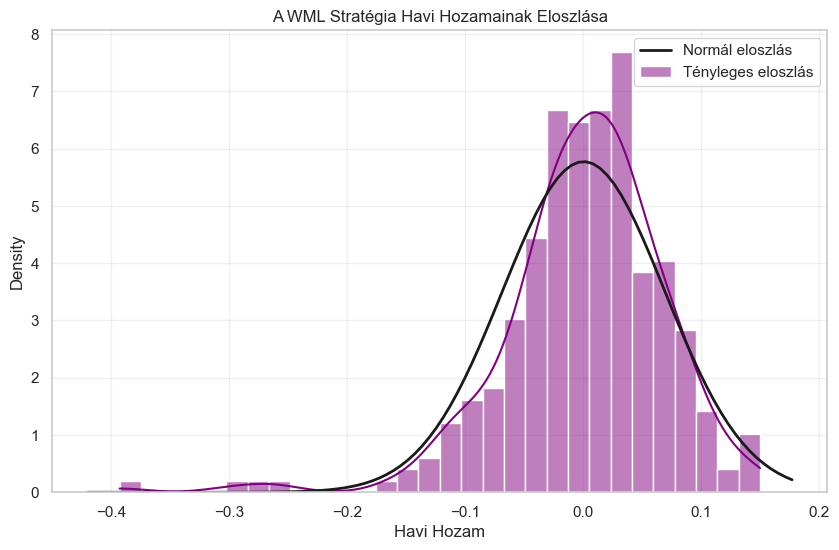

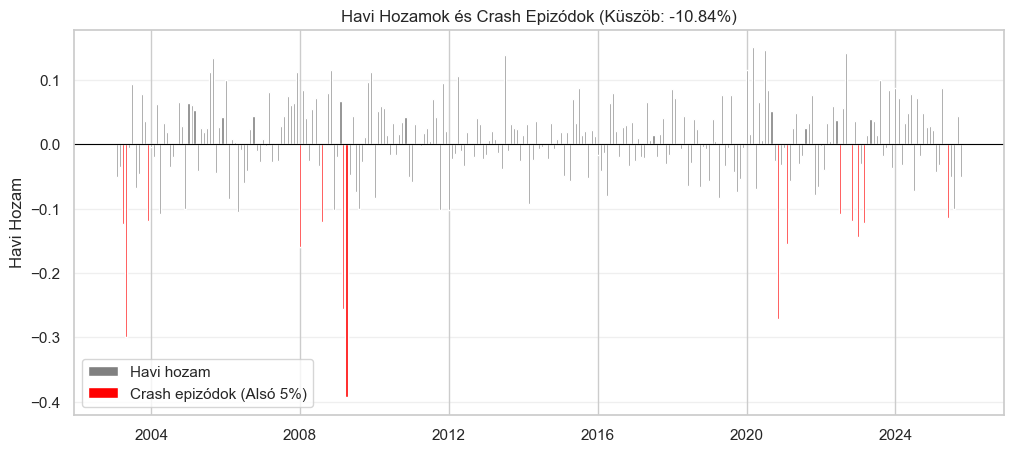

In [26]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- HIÁNYZÓ MUTATÓK ÉS VIZUALIZÁCIÓ (A feladat szerint) ---")

# 1. ADATOK ELŐKÉSZÍTÉSE
# Megkeressük a stratégia hozamait (long_short vagy wml_series néven)
target_series = None
if 'long_short' in locals():
    target_series = long_short
elif 'wml_series' in locals():
    target_series = wml_series
    print("(Megjegyzés: A 'wml_series' változót használjuk a 'long_short' helyett.)")

if target_series is not None:
    # Biztonsági másolat a tisztább kódért
    long_short = target_series.dropna()

    # ---------------------------------------------------------
    # 2. KOCKÁZATI MUTATÓK SZÁMÍTÁSA
    # ---------------------------------------------------------
    
    # Volatilitás
    vol_monthly = long_short.std()
    vol_annualized = vol_monthly * np.sqrt(12)
    
    # Évesített hozam
    mean_annualized = long_short.mean() * 12
    
    # Sharpe-ráta (Rf=0 feltételezéssel, mivel ez long-short)
    sharpe_ratio = mean_annualized / vol_annualized
    
    # Crash (Minimum hozam)
    min_return = long_short.min()
    crash_date = long_short.idxmin()
    
    print(f"Évesített Volatilitás: {vol_annualized:.2%}")
    print(f"Sharpe-ráta: {sharpe_ratio:.2f}")
    print(f"CRASH (Legrosszabb hónap): {min_return:.2%} ({crash_date.strftime('%Y-%m')})")

    # ---------------------------------------------------------
    # 3. VIZUALIZÁCIÓ
    # ---------------------------------------------------------
    
    # A) Eloszlás vizualizáció (Histogram + KDE)
    plt.figure(figsize=(10, 6))
    sns.histplot(long_short, kde=True, stat="density", color='purple', bins=30, label='Tényleges eloszlás')
    
    # Normál eloszlás görbe illesztése (referencia)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, long_short.mean(), long_short.std())
    plt.plot(x, p, 'k', linewidth=2, label='Normál eloszlás')
    
    plt.title('A WML Stratégia Havi Hozamainak Eloszlása')
    plt.xlabel('Havi Hozam')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # B) Crash epizódok vizualizációja (Bar Chart)
    plt.figure(figsize=(12, 5))
    
    # width=20 beállítása (kb. 20 nap szélesség), hogy látszódjanak az oszlopok dátumtengelyen
    plt.bar(long_short.index, long_short.values, color='gray', label='Havi hozam', width=20)
    
    # Kiemeljük a crash-eket (alsó 5%)
    # A quantile(0.05) az a határ, ami alatt a hozamok legrosszabb 5%-a van
    threshold = long_short.quantile(0.05)
    crashes = long_short[long_short < threshold]
    
    plt.bar(crashes.index, crashes.values, color='red', label='Crash epizódok (Alsó 5%)', width=20)
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f'Havi Hozamok és Crash Epizódok (Küszöb: {threshold:.2%})')
    plt.ylabel('Havi Hozam')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

else:
    print("HIBA: Nincs elérhető WML hozam adat (long_short vagy wml_series).")
    print("Kérlek futtasd le a korábbi, stratégia-építő cellákat!")

### 2. Feladat

--- 2. MOMENTUM CRASH-RISK ELEMZÉSE (Javított: Equal-Weighted Benchmark) ---
Elemzett hónapok száma: 273

Az 5 legrosszabb Momentum (Crash) hónap:
(A piaci hozam itt az SP100 részvények egyszerű átlaga - Equal Weighted)
---------------------------------------------------------------------------
Dátum           | WML Hozam    | Piaci Hozam (EW)    
---------------------------------------------------------------------------
2009-04         |    -39.31% |          11.02%
2003-05         |    -29.97% |           9.88%
2020-11         |    -27.10% |          13.59%
2009-03         |    -25.64% |          12.06%
2008-01         |    -16.02% |          -5.69%
---------------------------------------------------------------------------

Megfigyelés: 4 esetben a piac EMELKEDETT (pozitív Equal-Weighted hozam),
miközben a momentum összeomlott. Ez klasszikus 'Momentum Crash' (Short-squeeze) jelenség.
Ok: A korábbi vesztesek (Losers) hirtelen felpattantak (Junk Rally).


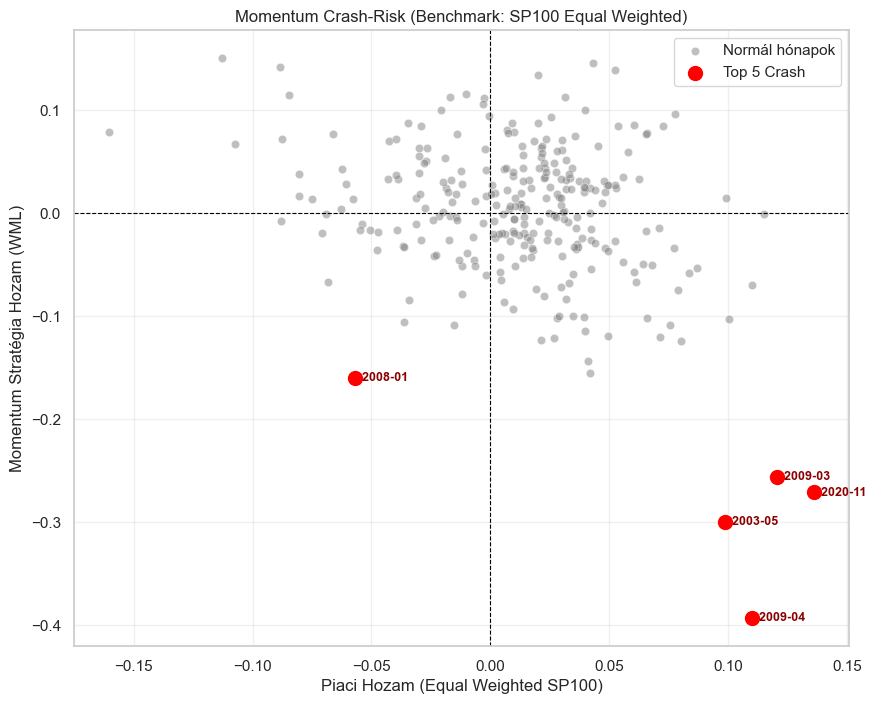

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 2. MOMENTUM CRASH-RISK ELEMZÉSE (Javított: Equal-Weighted Benchmark) ---")

try:
    # 1. ADATOK ELŐKÉSZÍTÉSE
    # Nem töltjük be újra fájlból, hanem a memóriában lévő tisztított adatokat használjuk
    if 'stock_returns' not in locals():
        raise ValueError("A 'stock_returns' változó hiányzik. Futtasd le az 1. cellát!")
    
    if 'wml_series' not in locals():
        # Megpróbáljuk a másik nevet is
        if 'wml_returns' in locals():
            wml_series = wml_returns
        elif 'long_short' in locals():
            wml_series = long_short
        else:
            raise ValueError("A 'wml_series' változó hiányzik. Futtasd le a Momentum számítást!")

    # 2. EQUAL-WEIGHTED BENCHMARK LÉTREHOZÁSA
    # Kiszámoljuk az összes (tisztított) részvény átlaghozamát minden hónapra
    # Ez jobban reprezentálja a stratégiában lévő részvények átlagos mozgását, mint az SP100 index.
    market_eq_weighted = stock_returns.mean(axis=1)
    market_eq_weighted.name = "SP100_Equal_Weighted"

    # 3. ÖSSZEFŰZÉS A WML HOZAMOKKAL
    # A wml_series indexe lehet, hogy rövidebb (a momentum képzés miatt), ezért inner join kell
    analysis_df = pd.DataFrame({
        'WML': wml_series,
        'Market_EQ': market_eq_weighted
    }).dropna()
    
    print(f"Elemzett hónapok száma: {len(analysis_df)}")

    # 4. AZ 5 LEGROSSZABB HÓNAP (CRASH)
    worst_5_months = analysis_df.nsmallest(5, 'WML')
    
    print("\nAz 5 legrosszabb Momentum (Crash) hónap:")
    print(f"(A piaci hozam itt az SP100 részvények egyszerű átlaga - Equal Weighted)")
    print("-" * 75)
    print(f"{'Dátum':<15} | {'WML Hozam':<12} | {'Piaci Hozam (EW)':<20}")
    print("-" * 75)
    for date, row in worst_5_months.iterrows():
        print(f"{date.strftime('%Y-%m'):<15} | {row['WML']:>10.2%} | {row['Market_EQ']:>15.2%}")
    print("-" * 75)
    
    # Értelmezés: Short-squeeze gyanú
    # Ha a piac emelkedett (>0), de a WML nagyot esett, az arra utal, 
    # hogy a vesztes részvények (amiket shortoltunk) hirtelen nagyot emelkedtek.
    bull_market_crashes = worst_5_months[worst_5_months['Market_EQ'] > 0]
    
    if not bull_market_crashes.empty:
        print(f"\nMegfigyelés: {len(bull_market_crashes)} esetben a piac EMELKEDETT (pozitív Equal-Weighted hozam),")
        print("miközben a momentum összeomlott. Ez klasszikus 'Momentum Crash' (Short-squeeze) jelenség.")
        print("Ok: A korábbi vesztesek (Losers) hirtelen felpattantak (Junk Rally).")

    # 5. SCATTER PLOT
    plt.figure(figsize=(10, 8))
    
    # Normál hónapok
    sns.scatterplot(data=analysis_df, x='Market_EQ', y='WML', alpha=0.5, color='gray', label='Normál hónapok')
    
    # Crash hónapok kiemelése
    plt.scatter(worst_5_months['Market_EQ'], worst_5_months['WML'], color='red', s=100, zorder=5, label='Top 5 Crash')
    
    # Címkék a crash hónapokhoz
    for date, row in worst_5_months.iterrows():
        plt.text(row['Market_EQ'], row['WML'], f"  {date.strftime('%Y-%m')}", 
                 fontsize=9, color='darkred', va='center', fontweight='bold')

    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    
    plt.title('Momentum Crash-Risk (Benchmark: SP100 Equal Weighted)')
    plt.xlabel('Piaci Hozam (Equal Weighted SP100)')
    plt.ylabel('Momentum Stratégia Hozam (WML)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('wml_crash_scatter_eq.png')
    plt.show()

except Exception as e:
    print(f"HIBA TÖRTÉNT: {e}")
    print("Ellenőrizd, hogy lefuttattad-e az előző cellákat (Adatbetöltés, Momentum számítás)!")

--- 3. MOMENTUM KOCKÁZAT (Volatilitás becslése havi adatokból) ---
Tisztított havi adatok használata: (285, 88)
WML hozamok számítása (Volatilitás elemzéshez)...

--- AR(1) Modell Eredmények (Becsült Havi Volatilitásra) ---
Modell: sigma^2_t = 0.000247 + 0.9392 * sigma^2_(t-1)
Perzisztencia (rho): 0.9392
R-négyzet (R^2):     0.8891

Megjegyzés: A 12 hónapos simítás miatt a perzisztencia itt mesterségesen magasabb lehet,
mint a napi adatokból számolt realizált volatilitásnál.


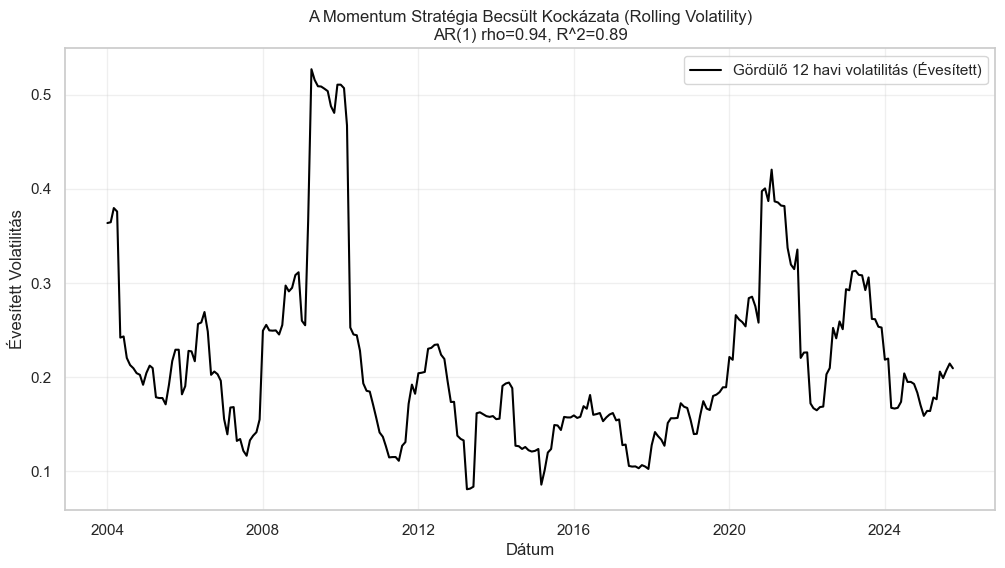

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

print("--- 3. MOMENTUM KOCKÁZAT (Volatilitás becslése havi adatokból) ---")

try:
    # 1. ADATOK ELŐKÉSZÍTÉSE (Memóriából)
    # Nem töltjük be újra a fájlt, hanem a már tisztított 'stock_returns' változót használjuk.
    if 'stock_returns' in locals():
        stock_ret_m = stock_returns
        print(f"Tisztított havi adatok használata: {stock_ret_m.shape}")
    else:
        raise ValueError("A 'stock_returns' változó hiányzik. Futtasd le az adatbetöltő cellát!")

    # 2. WML HAVI IDŐSOR GENERÁLÁSA (Ha még nem lenne meg)
    # Ha a 'wml_series' már létezik a korábbi cellákból, használhatnánk azt is,
    # de a biztonság kedvéért itt újraszámoljuk a logikát.
    
    # Momentum szignál (12-2)
    momentum_signal = (1 + stock_ret_m.shift(2)).rolling(window=11).apply(np.prod, raw=True) - 1

    wml_returns = []
    dates = []

    print("WML hozamok számítása (Volatilitás elemzéshez)...")

    for date, row in momentum_signal.iterrows():
        # Csak érvényes dátumokon
        if date not in stock_ret_m.index: continue
        
        valid = row.dropna()
        if len(valid) < 10: continue

        # Decilisek
        p10 = valid.quantile(0.10)
        p90 = valid.quantile(0.90)
        
        winners = valid[valid >= p90].index
        losers = valid[valid <= p10].index
        
        curr = stock_ret_m.loc[date]
        
        # Havi WML hozam
        r_wml = curr[winners].mean() - curr[losers].mean()
        
        wml_returns.append(r_wml)
        dates.append(date)

    wml_series_monthly = pd.Series(wml_returns, index=dates).dropna()
    wml_series_monthly.name = "WML_Monthly"
    
    # 3. VOLATILITÁS BECSLÉSE HAVI ADATOKBÓL (Rolling Window)
    # Mivel ebben a blokkban feltételezzük, hogy csak havi adatunk van,
    # egy 12 hónapos gördülő szórással becsüljük a volatilitást.
    
    # Gördülő szórás (12 hónap)
    rolling_vol = wml_series_monthly.rolling(window=12).std()
    
    # Évesített volatilitás (havi szórás * gyök(12))
    ann_rolling_vol = rolling_vol * np.sqrt(12)
    
    # Variancia (a regresszióhoz: sigma^2)
    rolling_var = rolling_vol ** 2
    
    # 4. AR(1) MODELL
    # Y = Var_t, X = Var_t-1
    data_reg = pd.DataFrame({
        'Var_t': rolling_var,
        'Var_t-1': rolling_var.shift(1)
    }).dropna()
    
    if not data_reg.empty:
        Y = data_reg['Var_t']
        X = sm.add_constant(data_reg['Var_t-1'])
        
        model = sm.OLS(Y, X).fit()
        
        rho = model.params['Var_t-1']
        alpha = model.params['const']
        r_squared = model.rsquared
        
        print(f"\n--- AR(1) Modell Eredmények (Becsült Havi Volatilitásra) ---")
        print(f"Modell: sigma^2_t = {alpha:.6f} + {rho:.4f} * sigma^2_(t-1)")
        print(f"Perzisztencia (rho): {rho:.4f}")
        print(f"R-négyzet (R^2):     {r_squared:.4f}")
        
        print("\nMegjegyzés: A 12 hónapos simítás miatt a perzisztencia itt mesterségesen magasabb lehet,")
        print("mint a napi adatokból számolt realizált volatilitásnál.")
        
        # 5. VIZUALIZÁCIÓ
        plt.figure(figsize=(12, 6))
        
        # Volatilitás ábrázolása
        plt.plot(ann_rolling_vol, color='black', linewidth=1.5, label='Gördülő 12 havi volatilitás (Évesített)')
        
        plt.title(f"A Momentum Stratégia Becsült Kockázata (Rolling Volatility)\nAR(1) rho={rho:.2f}, R^2={r_squared:.2f}")
        plt.ylabel("Évesített Volatilitás")
        plt.xlabel("Dátum")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.savefig('momentum_volatility_monthly_rolling.png')
        plt.show()
    else:
        print("Nincs elég adat a regresszióhoz (túl rövid idősor).")

except Exception as e:
    print(f"Hiba történt: {e}")
    print("Ellenőrizd, hogy a 'stock_returns' változó be van-e töltve!")

### 3. feladat

--- 3. A MOMENTUM IDŐBEN VÁLTOZÓ KOCKÁZATA (Realizált Volatilitás) ---
Havi adatok betöltve a memóriából (Már tisztítva).
Adatok mérete -> Havi: (285, 88), Napi (Szűrt): (5998, 88)
Realizált volatilitás számítása (ez eltarthat egy percig)...

--- AR(1) Modell Eredmények ---
Modell: sigma^2_t = 0.01900 + 0.7054 * sigma^2_(t-1)
Becsült perzisztencia (rho): 0.7054
Magyarázó erő (R^2): 0.4977
-> EREDMÉNY: Magas perzisztencia! (A kockázat 'ragadós')


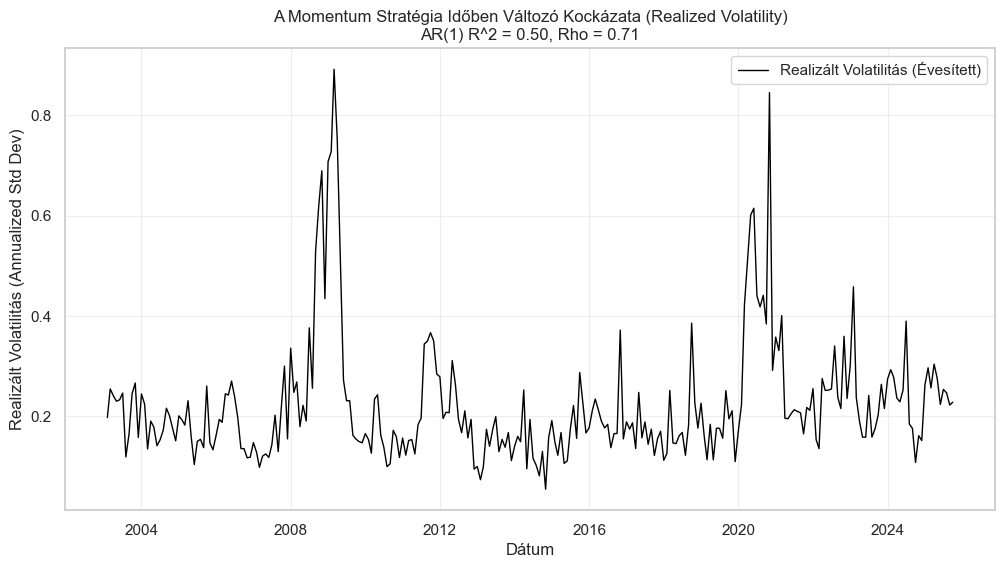

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

print("--- 3. A MOMENTUM IDŐBEN VÁLTOZÓ KOCKÁZATA (Realizált Volatilitás) ---")

try:
    # 1. ADATOK BETÖLTÉSE
    
    # --- A) Havi adatok (a portfólió összetételhez) ---
    if 'stock_returns' in locals():
        stock_ret_m = stock_returns
        print("Havi adatok betöltve a memóriából (Már tisztítva).")
    else:
        df_monthly = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
        if not isinstance(df_monthly.index, pd.DatetimeIndex):
             df_monthly.index = pd.to_datetime(df_monthly.index)
        stock_ret_m = df_monthly
        print("Havi adatok betöltve fájlból.")

    # --- B) Napi adatok (a volatilitás számításhoz) ---
    df_daily = pd.read_csv('daily_stock_returns.csv', index_col=0, parse_dates=True)
    
    # Biztonsági ellenőrzés: dátum index
    if not isinstance(df_daily.index, pd.DatetimeIndex):
        df_daily.index = pd.to_datetime(df_daily.index)

    # --- C) NAPI ADATOK TISZTÍTÁSA (AZONOS ELV ALAPJÁN) ---
    # Csak azokat a részvényeket (oszlopokat) hagyjuk meg a napi adatokban,
    # amelyek a tisztított havi adatokban (stock_ret_m) is szerepelnek.
    # Így biztosan ugyanazon az univerzumon dolgozunk (pl. Facebook itt is kikerül, ha ott nem volt).
    
    valid_tickers = stock_ret_m.columns
    # Metszetet képzünk, hogy elkerüljük a hibát, ha valami néveltérés lenne
    common_cols = df_daily.columns.intersection(valid_tickers)
    
    # Felülírjuk a df_daily-t a szűrt változattal
    df_daily = df_daily[common_cols]

    print(f"Adatok mérete -> Havi: {stock_ret_m.shape}, Napi (Szűrt): {df_daily.shape}")

    # 2. HAVI MOMENTUM SZIGNÁL ÉS PORTFÓLIÓK MEGHATÁROZÁSA
    # Szignál számítása a tisztított havi adatokon
    momentum_signal = (1 + stock_ret_m.shift(2)).rolling(window=11).apply(np.prod, raw=True) - 1

    # 3. NAPI WML HOZAMOK ÉS HAVI REALIZÁLT VOLATILITÁS SZÁMÍTÁSA
    realized_vol_list = []
    
    print("Realizált volatilitás számítása (ez eltarthat egy percig)...")

    # Végigmegyünk minden hónapon (ahol van szignál)
    for month_date, row in momentum_signal.iterrows():
        # Csak érvényes dátumokon
        if month_date not in stock_ret_m.index: continue

        valid_signals = row.dropna()
        if len(valid_signals) < 10: continue

        # --- A) Portfólió kiválasztása (Top/Bottom 10%) ---
        p10 = valid_signals.quantile(0.10)
        p90 = valid_signals.quantile(0.90)
        
        winners = valid_signals[valid_signals >= p90].index
        losers = valid_signals[valid_signals <= p10].index
        
        # --- B) Napi adatok kinyerése az ADOTT hónapra ---
        year = month_date.year
        month = month_date.month
        
        # Napi szeletelés (csak az adott év/hónap napjai)
        daily_slice = df_daily[
            (df_daily.index.year == year) & (df_daily.index.month == month)
        ]
        
        if daily_slice.empty: continue
        
        # Csak azok a részvények kellenek, amik a portfólióban vannak
        # Mivel már szűrtük a df_daily-t az elején, itt elvileg minden winner/loser
        # benne kell legyen a daily-ben is (ha van adat arra a napra).
        w_tickers = winners.intersection(daily_slice.columns)
        l_tickers = losers.intersection(daily_slice.columns)
        
        if len(w_tickers) == 0 or len(l_tickers) == 0: continue

        # --- C) Napi WML hozam számítása ---
        # (Napi Winner Átlag - Napi Loser Átlag)
        d_win = daily_slice[w_tickers].mean(axis=1)
        d_lose = daily_slice[l_tickers].mean(axis=1)
        d_wml = d_win - d_lose
        
        # --- D) REALIZÁLT VOLATILITÁS (RV) ---
        # Napi hozamok szórása az adott hónapban
        vol_month = d_wml.std()
        
        # Évesítés (Napi szórás * gyök(252))
        vol_ann = vol_month * np.sqrt(252)
        
        realized_vol_list.append({'Date': month_date, 'Vol_Daily': vol_month, 'Vol_Ann': vol_ann})

    # DataFrame készítése az eredményből
    vol_df = pd.DataFrame(realized_vol_list).set_index('Date')
    
    # 4. AR(1) MODELL FUTTATÁSA A VARIANCIÁRA
    # Modell: sigma^2_t = alpha + rho * sigma^2_{t-1} + e
    
    # Variancia számítása
    variance_t = vol_df['Vol_Ann'] ** 2
    
    # Előkészítés a regresszióhoz (Lag-1)
    reg_data = pd.DataFrame({
        'Var_t': variance_t,
        'Var_t-1': variance_t.shift(1)
    }).dropna()
    
    if not reg_data.empty:
        # OLS Regresszió
        Y = reg_data['Var_t']
        X = sm.add_constant(reg_data['Var_t-1']) # Konstans (alpha)
        
        model = sm.OLS(Y, X).fit()
        
        alpha = model.params['const']
        rho = model.params['Var_t-1']
        r2 = model.rsquared
        
        print(f"\n--- AR(1) Modell Eredmények ---")
        print(f"Modell: sigma^2_t = {alpha:.5f} + {rho:.4f} * sigma^2_(t-1)")
        print(f"Becsült perzisztencia (rho): {rho:.4f}")
        print(f"Magyarázó erő (R^2): {r2:.4f}")
        
        if rho > 0.5:
            print("-> EREDMÉNY: Magas perzisztencia! (A kockázat 'ragadós')")

        # 5. VIZUALIZÁCIÓ
        plt.figure(figsize=(12, 6))
        plt.plot(vol_df['Vol_Ann'], color='black', linewidth=1, label='Realizált Volatilitás (Évesített)')
        
        plt.title(f"A Momentum Stratégia Időben Változó Kockázata (Realized Volatility)\nAR(1) R^2 = {r2:.2f}, Rho = {rho:.2f}")
        plt.ylabel("Realizált Volatilitás (Annualized Std Dev)")
        plt.xlabel("Dátum")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.savefig('momentum_realized_vol.png')
        plt.show()
    else:
        print("Nincs elég adat a regresszióhoz.")

except FileNotFoundError:
    print("HIBA: Nem található a 'daily_stock_returns.csv'!")
    print("Kérlek, futtasd le a downloader.ipynb kódot!")
except Exception as e:
    print(f"Hiba történt: {e}")